In [87]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply,Lambda,Flatten,Dropout
from tensorflow.keras.models import Model


In [17]:
def channel_Attention_module(x,ratio=8):
    batch,_,_,channel=x.shape
    l1=Dense(channel//ratio,activation="relu", use_bias=False)
    l2=Dense(channel,use_bias=False)

    x1=GlobalMaxPooling2D()(x)
    x1=l1(x1)
    x1=l2(x1)

    x2=GlobalAveragePooling2D()(x)
    x2=l1(x2)
    x2=l2(x2)
    feats=x1+x2
    activation=Activation("sigmoid")(feats)
    feats=Multiply()([x,feats])
    return feats

In [31]:
def spatial_attention_module(x):
     avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1))(x)
     x1=Lambda(lambda x: tf.expand_dims(x, axis=-1))(avg_pool)
     max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1))(x)
     x2=Lambda(lambda x: tf.expand_dims(x, axis=-1))(max_pool)
     feats=Concatenate()([x1,x2])
     conv=Conv2D(1,kernel_size=7,padding="same", activation="sigmoid")(feats)
     ret=Multiply()([conv,x])
     return ret

In [52]:
def CBAM(x):
    x=channel_Attention_module(x)
    x=spatial_attention_module(x)
    return x

In [103]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.2,
        fill_mode='nearest')

batch_size = 32
train_generator = datagen.flow_from_directory(
    '/kaggle/input/ck-dataset',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',   
    subset='training',
    shuffle=True
)
val_generator = datagen.flow_from_directory(
    '/kaggle/input/ck-dataset',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 788 images belonging to 7 classes.
Found 981 images belonging to 7 classes.


In [104]:
from tensorflow.keras.applications import ResNet50



mobile_base = MobileNet(
    input_shape=(150,150, 3),  # Can change to (96, 96, 3) for faster/smaller models
    alpha=1,                  # Controls model size (1.0 = full, 0.5 = smaller)
    include_top=False,         # Exclude final classification layer (for custom tasks)
    weights='imagenet'         # Use pretrained ImageNet weights
)
for layer in mobile_base.layers:
    layer.trainable = False

/tmp/ipykernel_36/1195538821.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile_base = MobileNet(


In [105]:
x=mobile_base.output
x=CBAM(x)
x = Flatten()(x)
x=Dense(256,activation="relu")(x)
x=Dropout(0.3)(x)
x=Dense(128,activation="relu")(x)
output = Dense(7,activation="softmax")(x)

In [106]:
mobile= Model(inputs=mobile_base.input, outputs=output)

In [107]:
mobile.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [108]:
movile_his =mobile.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 600ms/step - accuracy: 0.2335 - loss: 5.3642 - val_accuracy: 0.4832 - val_loss: 1.4745
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step - accuracy: 0.5093 - loss: 1.4727 - val_accuracy: 0.5739 - val_loss: 1.2647
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step - accuracy: 0.5621 - loss: 1.2500 - val_accuracy: 0.6096 - val_loss: 1.1541
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - accuracy: 0.5963 - loss: 1.1904 - val_accuracy: 0.6279 - val_loss: 1.0334
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - accuracy: 0.6250 - loss: 1.1087 - val_accuracy: 0.6391 - val_loss: 0.9931
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step - accuracy: 0.6534 - loss: 0.9774 - val_accuracy: 0.6667 - val_loss: 1.0115
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - accuracy: 0.6282 - loss: 1.0018 - val_accuracy: 0.6840 - val_loss: 0.8803
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 401ms/step - accuracy: 0.6946 - loss: 0.9527 - val_accu

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
import tensorflow as tf
import random

# Create test generator (no data augmentation for testing)
# test_datagen = ImageDataGenerator(rescale=1./255)

# test_generator = test_datagen.flow_from_directory(
#     '/kaggle/input/ck-dataset',
#     target_size=(150, 150),
#     batch_size=1,  # Set to 1 for individual image processing
#     class_mode='categorical',
#     shuffle=True  # Enable shuffling to get random images
# )

def create_attention_model(trained_model):
    """
    Create a model that outputs intermediate attention maps from CBAM module
    """
    # Extract outputs at different stages
    # Adjust these indices based on your model architecture
    mobilenet_output = None
    channel_attention_output = None
    spatial_attention_output = None
    
    # Find the relevant layers
    for i, layer in enumerate(trained_model.layers):
        if 'mobilenet' in layer.name.lower() or i == 1:  # MobileNet base
            mobilenet_output = layer.output
        elif 'multiply' in layer.name.lower():
            if channel_attention_output is None:
                channel_attention_output = layer.output
            else:
                spatial_attention_output = layer.output
    
    # If we can't find multiply layers, let's use a different approach
    if spatial_attention_output is None:
        # Get the output just before flatten
        for layer in reversed(trained_model.layers):
            if len(layer.output.shape) == 4:  # 4D tensor (batch, height, width, channels)
                spatial_attention_output = layer.output
                break
    
    attention_model = Model(
        inputs=trained_model.input,
        outputs=[mobilenet_output, spatial_attention_output]
    )
    
    return attention_model

def visualize_random_test_attention(model, test_gen, num_images=10, figsize=(20, 25)):
    """
    Visualize attention maps for random images from test generator
    
    Args:
        model: Your trained CBAM model
        test_gen: Test data generator
        num_images: Number of random images to visualize
        figsize: Figure size for matplotlib
    """
    
    # Get class names from generator
    class_names = list(test_gen.class_indices.keys())
    
    # Create attention model
    attention_model = create_attention_model(model)
    
    # Create subplot grid: 4 columns (original, spatial attention, overlay, prediction bars)
    fig, axes = plt.subplots(num_images, 4, figsize=figsize)
    
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    print(f"Generating attention visualizations for {num_images} random test images...")
    
    for i in range(num_images):
        # Get a random batch from test generator
        img_batch, label_batch = next(test_gen)
        img_array = img_batch[0]  # Get first (and only) image from batch
        true_label = np.argmax(label_batch[0])
        
        # Get model predictions
        prediction = model.predict(np.expand_dims(img_array, axis=0), verbose=0)
        predicted_class = np.argmax(prediction[0])
        confidence = np.max(prediction[0])
        
        # Get attention maps
        try:
            mobilenet_features, attention_features = attention_model.predict(
                np.expand_dims(img_array, axis=0), verbose=0
            )
        except:
            # Fallback: use the final convolutional features
            intermediate_model = Model(inputs=model.input, outputs=model.layers[-4].output)
            attention_features = intermediate_model.predict(np.expand_dims(img_array, axis=0), verbose=0)
        
        # Original image
        axes[i, 0].imshow(img_array)
        axes[i, 0].set_title(f'Original Image\nTrue: {class_names[true_label]}')
        axes[i, 0].axis('off')
        
        # Spatial attention map
        if len(attention_features.shape) == 4:
            spatial_map = np.mean(attention_features[0], axis=-1)
        else:
            spatial_map = attention_features[0]
        
        im1 = axes[i, 1].imshow(spatial_map, cmap='jet')
        axes[i, 1].set_title('Spatial Attention Map')
        axes[i, 1].axis('off')
        
        # Attention overlay
        attention_resized = cv2.resize(spatial_map, (150, 150))
        attention_normalized = (attention_resized - attention_resized.min()) / (
            attention_resized.max() - attention_resized.min() + 1e-8
        )
        
        # Create overlay
        overlay = plt.cm.jet(attention_normalized)[:, :, :3]
        blended = 0.6 * img_array + 0.4 * overlay
        
        axes[i, 2].imshow(np.clip(blended, 0, 1))
        axes[i, 2].set_title(f'Attention Overlay\nPred: {class_names[predicted_class]} ({confidence:.2f})')
        axes[i, 2].axis('off')
        
        # Prediction confidence bars
        y_pos = np.arange(len(class_names))
        colors = ['green' if j == predicted_class else 'blue' if j == true_label else 'gray' 
                 for j in range(len(class_names))]
        
        bars = axes[i, 3].barh(y_pos, prediction[0], color=colors, alpha=0.7)
        axes[i, 3].set_yticks(y_pos)
        axes[i, 3].set_yticklabels(class_names, fontsize=8)
        axes[i, 3].set_xlabel('Confidence')
        axes[i, 3].set_title('Class Predictions')
        axes[i, 3].set_xlim(0, 1)
        
        # Add confidence values on bars
        for j, (bar, conf) in enumerate(zip(bars, prediction[0])):
            if conf > 0.05:  # Only show if confidence > 5%
                axes[i, 3].text(conf + 0.01, bar.get_y() + bar.get_height()/2, 
                               f'{conf:.2f}', ha='left', va='center', fontsize=7)
        
        print(f"Image {i+1}/{num_images} - True: {class_names[true_label]}, "
              f"Pred: {class_names[predicted_class]} ({confidence:.3f})")
    
    plt.tight_layout()
    plt.show()
    
    return fig

def analyze_attention_statistics(model, test_gen, num_samples=50):
    """
    Analyze attention patterns across multiple test images
    
    Args:
        model: Your trained CBAM model
        test_gen: Test data generator
        num_samples: Number of images to analyze
    """
    
    class_names = list(test_gen.class_indices.keys())
    attention_model = create_attention_model(model)
    
    attention_stats = {class_name: [] for class_name in class_names}
    correct_predictions = 0
    
    print(f"Analyzing attention patterns for {num_samples} images...")
    
    for i in range(num_samples):
        img_batch, label_batch = next(test_gen)
        img_array = img_batch[0]
        true_label = np.argmax(label_batch[0])
        true_class = class_names[true_label]
        
        # Get predictions
        prediction = model.predict(np.expand_dims(img_array, axis=0), verbose=0)
        predicted_class = np.argmax(prediction[0])
        
        if predicted_class == true_label:
            correct_predictions += 1
        
        # Get attention map
        try:
            _, attention_features = attention_model.predict(
                np.expand_dims(img_array, axis=0), verbose=0
            )
            
            if len(attention_features.shape) == 4:
                spatial_map = np.mean(attention_features[0], axis=-1)
            else:
                spatial_map = attention_features[0]
            
            # Calculate attention statistics
            attention_mean = np.mean(spatial_map)
            attention_std = np.std(spatial_map)
            attention_max = np.max(spatial_map)
            attention_focus = np.sum(spatial_map > (attention_mean + attention_std)) / spatial_map.size
            
            attention_stats[true_class].append({
                'mean': attention_mean,
                'std': attention_std,
                'max': attention_max,
                'focus_ratio': attention_focus,
                'correct': predicted_class == true_label
            })
            
        except Exception as e:
            print(f"Error processing image {i}: {e}")
            continue
    
    # Display statistics
    print(f"\nOverall Accuracy: {correct_predictions/num_samples:.3f}")
    print("\nAttention Statistics by Class:")
    print("-" * 60)
    
    for class_name, stats_list in attention_stats.items():
        if stats_list:
            avg_mean = np.mean([s['mean'] for s in stats_list])
            avg_std = np.mean([s['std'] for s in stats_list])
            avg_focus = np.mean([s['focus_ratio'] for s in stats_list])
            class_accuracy = np.mean([s['correct'] for s in stats_list])
            
            print(f"{class_name:10} | Att.Mean: {avg_mean:.3f} | Att.Std: {avg_std:.3f} | "
                  f"Focus: {avg_focus:.3f} | Accuracy: {class_accuracy:.3f}")
    
    return attention_stats

# Example usage:
"""
# Visualize 10 random test images with attention
fig = visualize_random_test_attention(mobile, test_generator, num_images=10)

# Analyze attention patterns across more images
attention_stats = analyze_attention_statistics(mobile, test_generator, num_samples=100)
"""

print("Functions created successfully!")
print("Usage:")
print("1. visualize_random_test_attention(mobile, test_generator, num_images=10)")
print("2. analyze_attention_statistics(mobile, test_generator, num_samples=50)")

Functions created successfully!
Usage:
1. visualize_random_test_attention(mobile, test_generator, num_images=10)
2. analyze_attention_statistics(mobile, test_generator, num_samples=50)


Generating attention visualizations for 10 random test images...
Image 1/10 - True: surprise, Pred: surprise (0.986)
Image 2/10 - True: surprise, Pred: surprise (1.000)
Image 3/10 - True: surprise, Pred: surprise (1.000)
Image 4/10 - True: anger, Pred: disgust (0.492)
Image 5/10 - True: anger, Pred: anger (0.371)
Image 6/10 - True: anger, Pred: anger (0.323)
Image 7/10 - True: anger, Pred: anger (0.376)
Image 8/10 - True: anger, Pred: anger (0.505)
Image 9/10 - True: contempt, Pred: happy (0.486)
Image 10/10 - True: disgust, Pred: disgust (1.000)


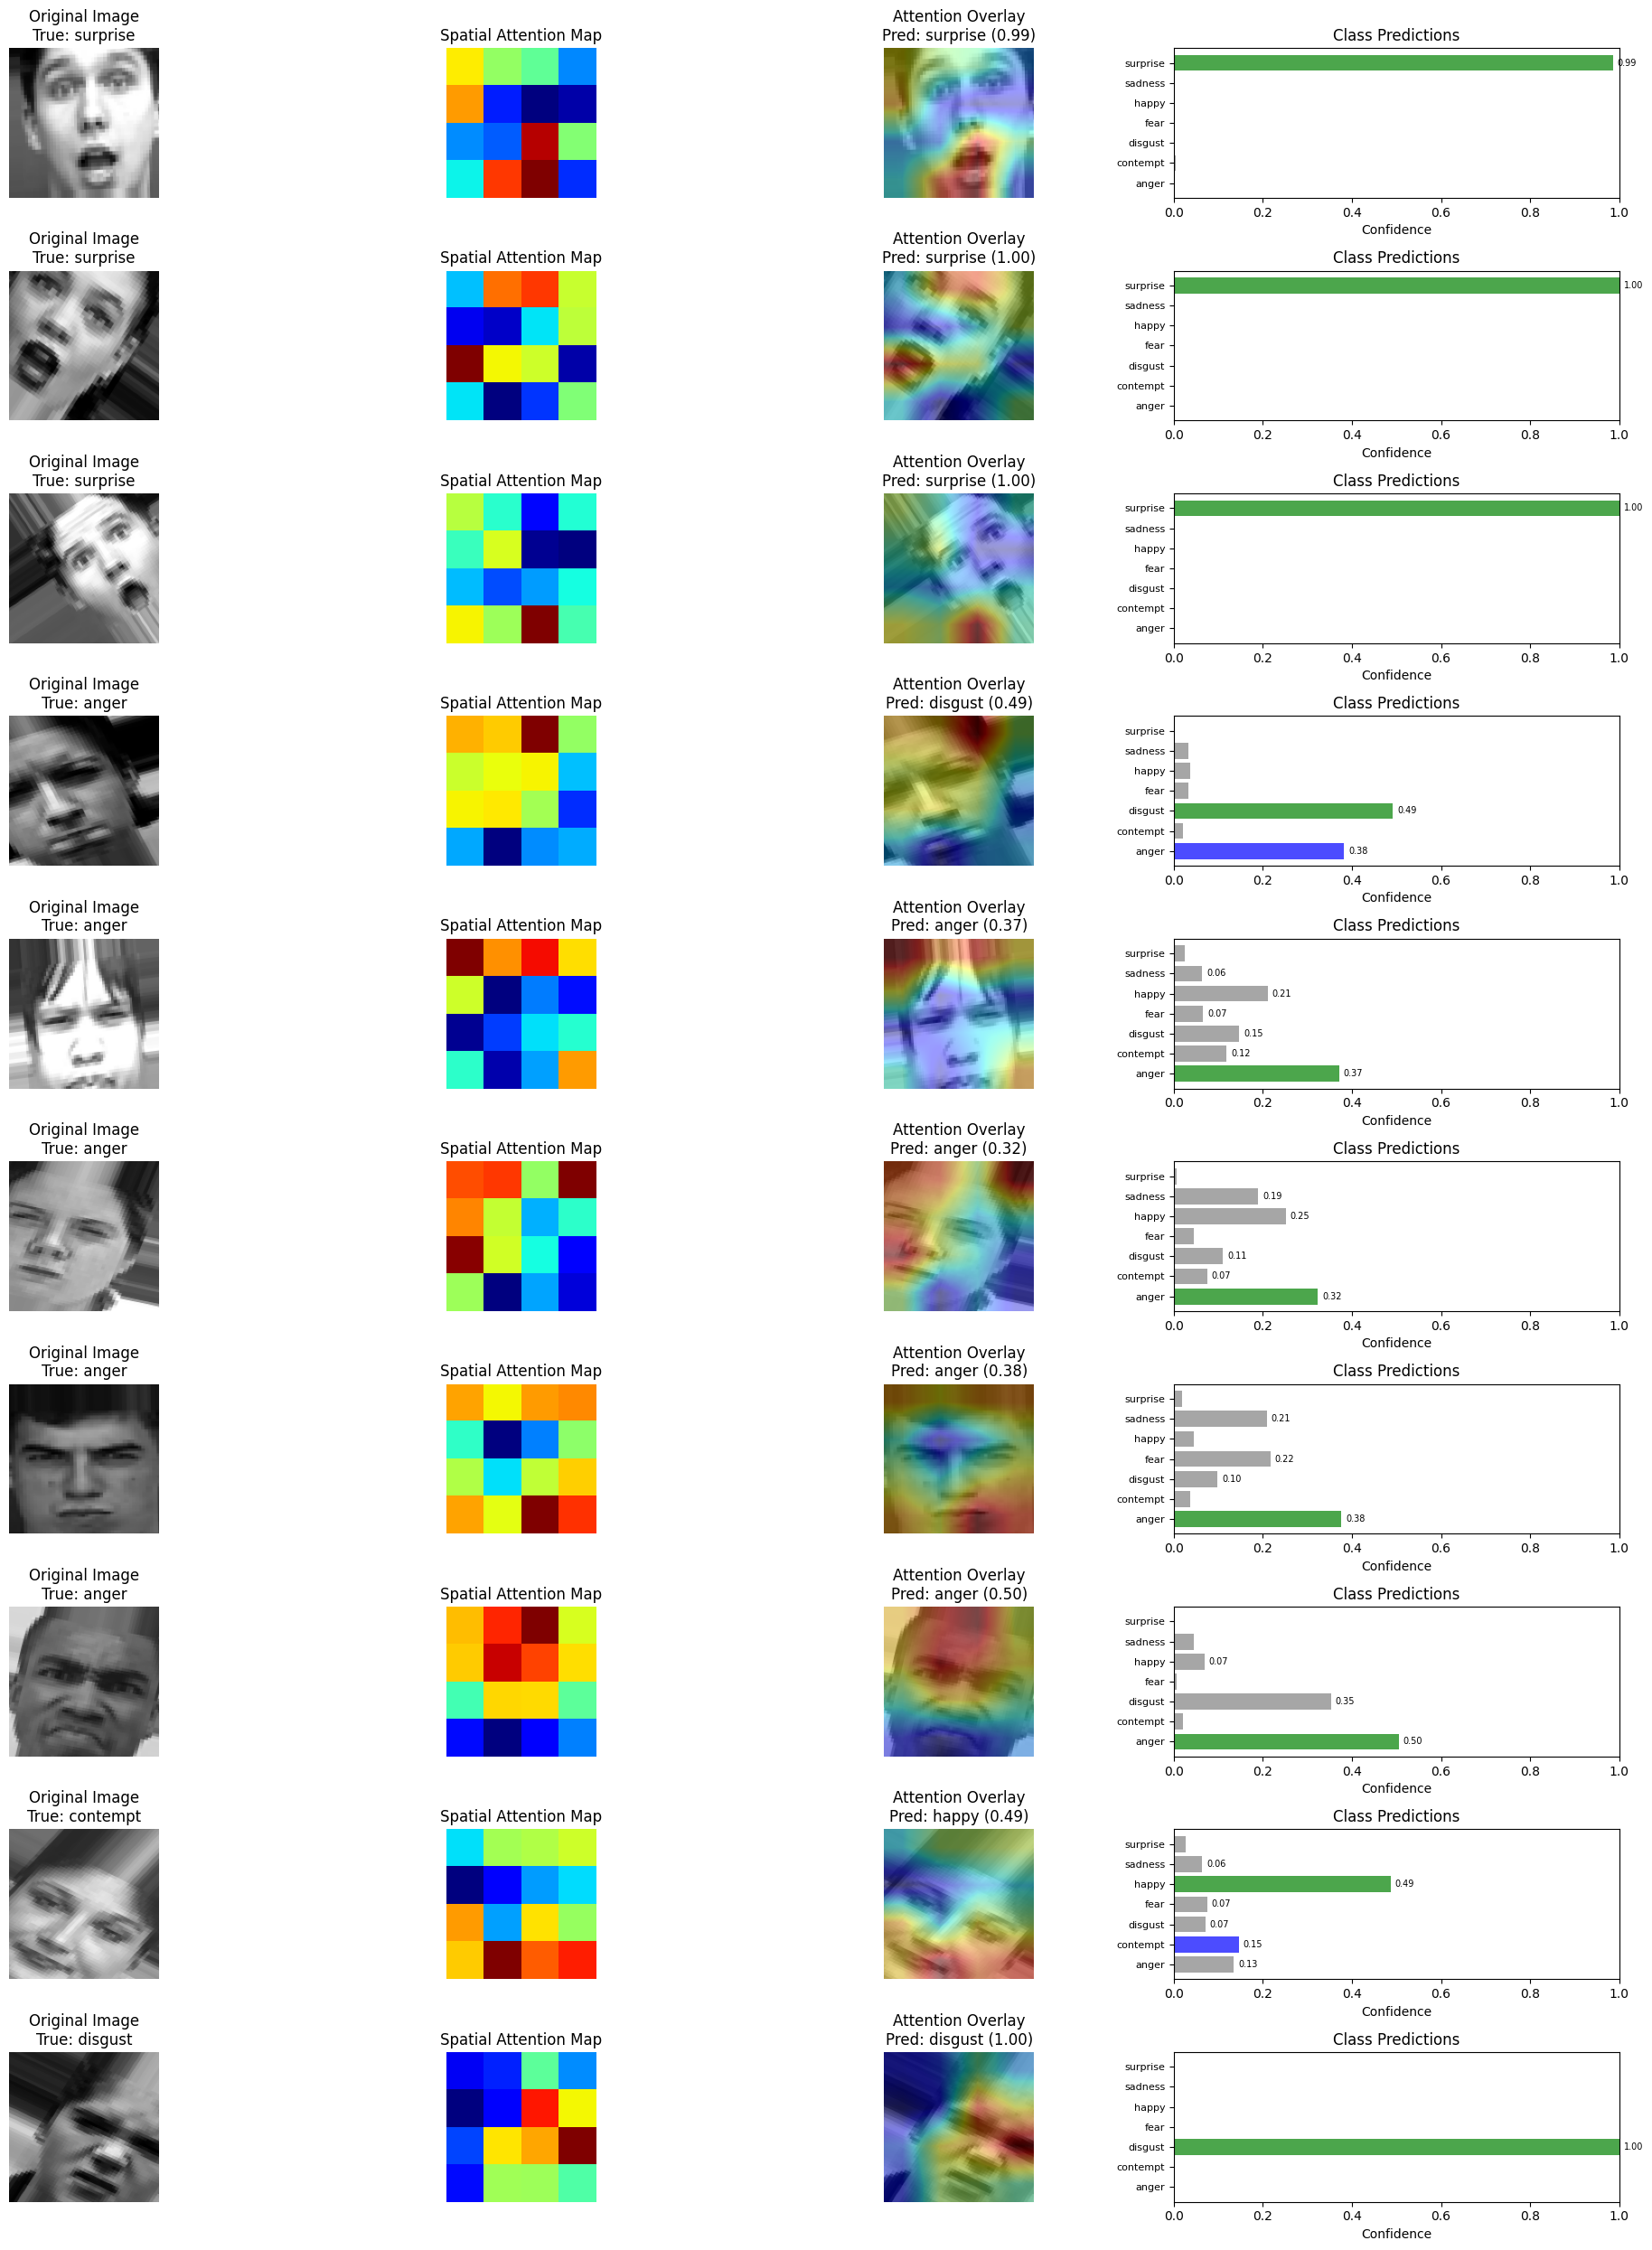

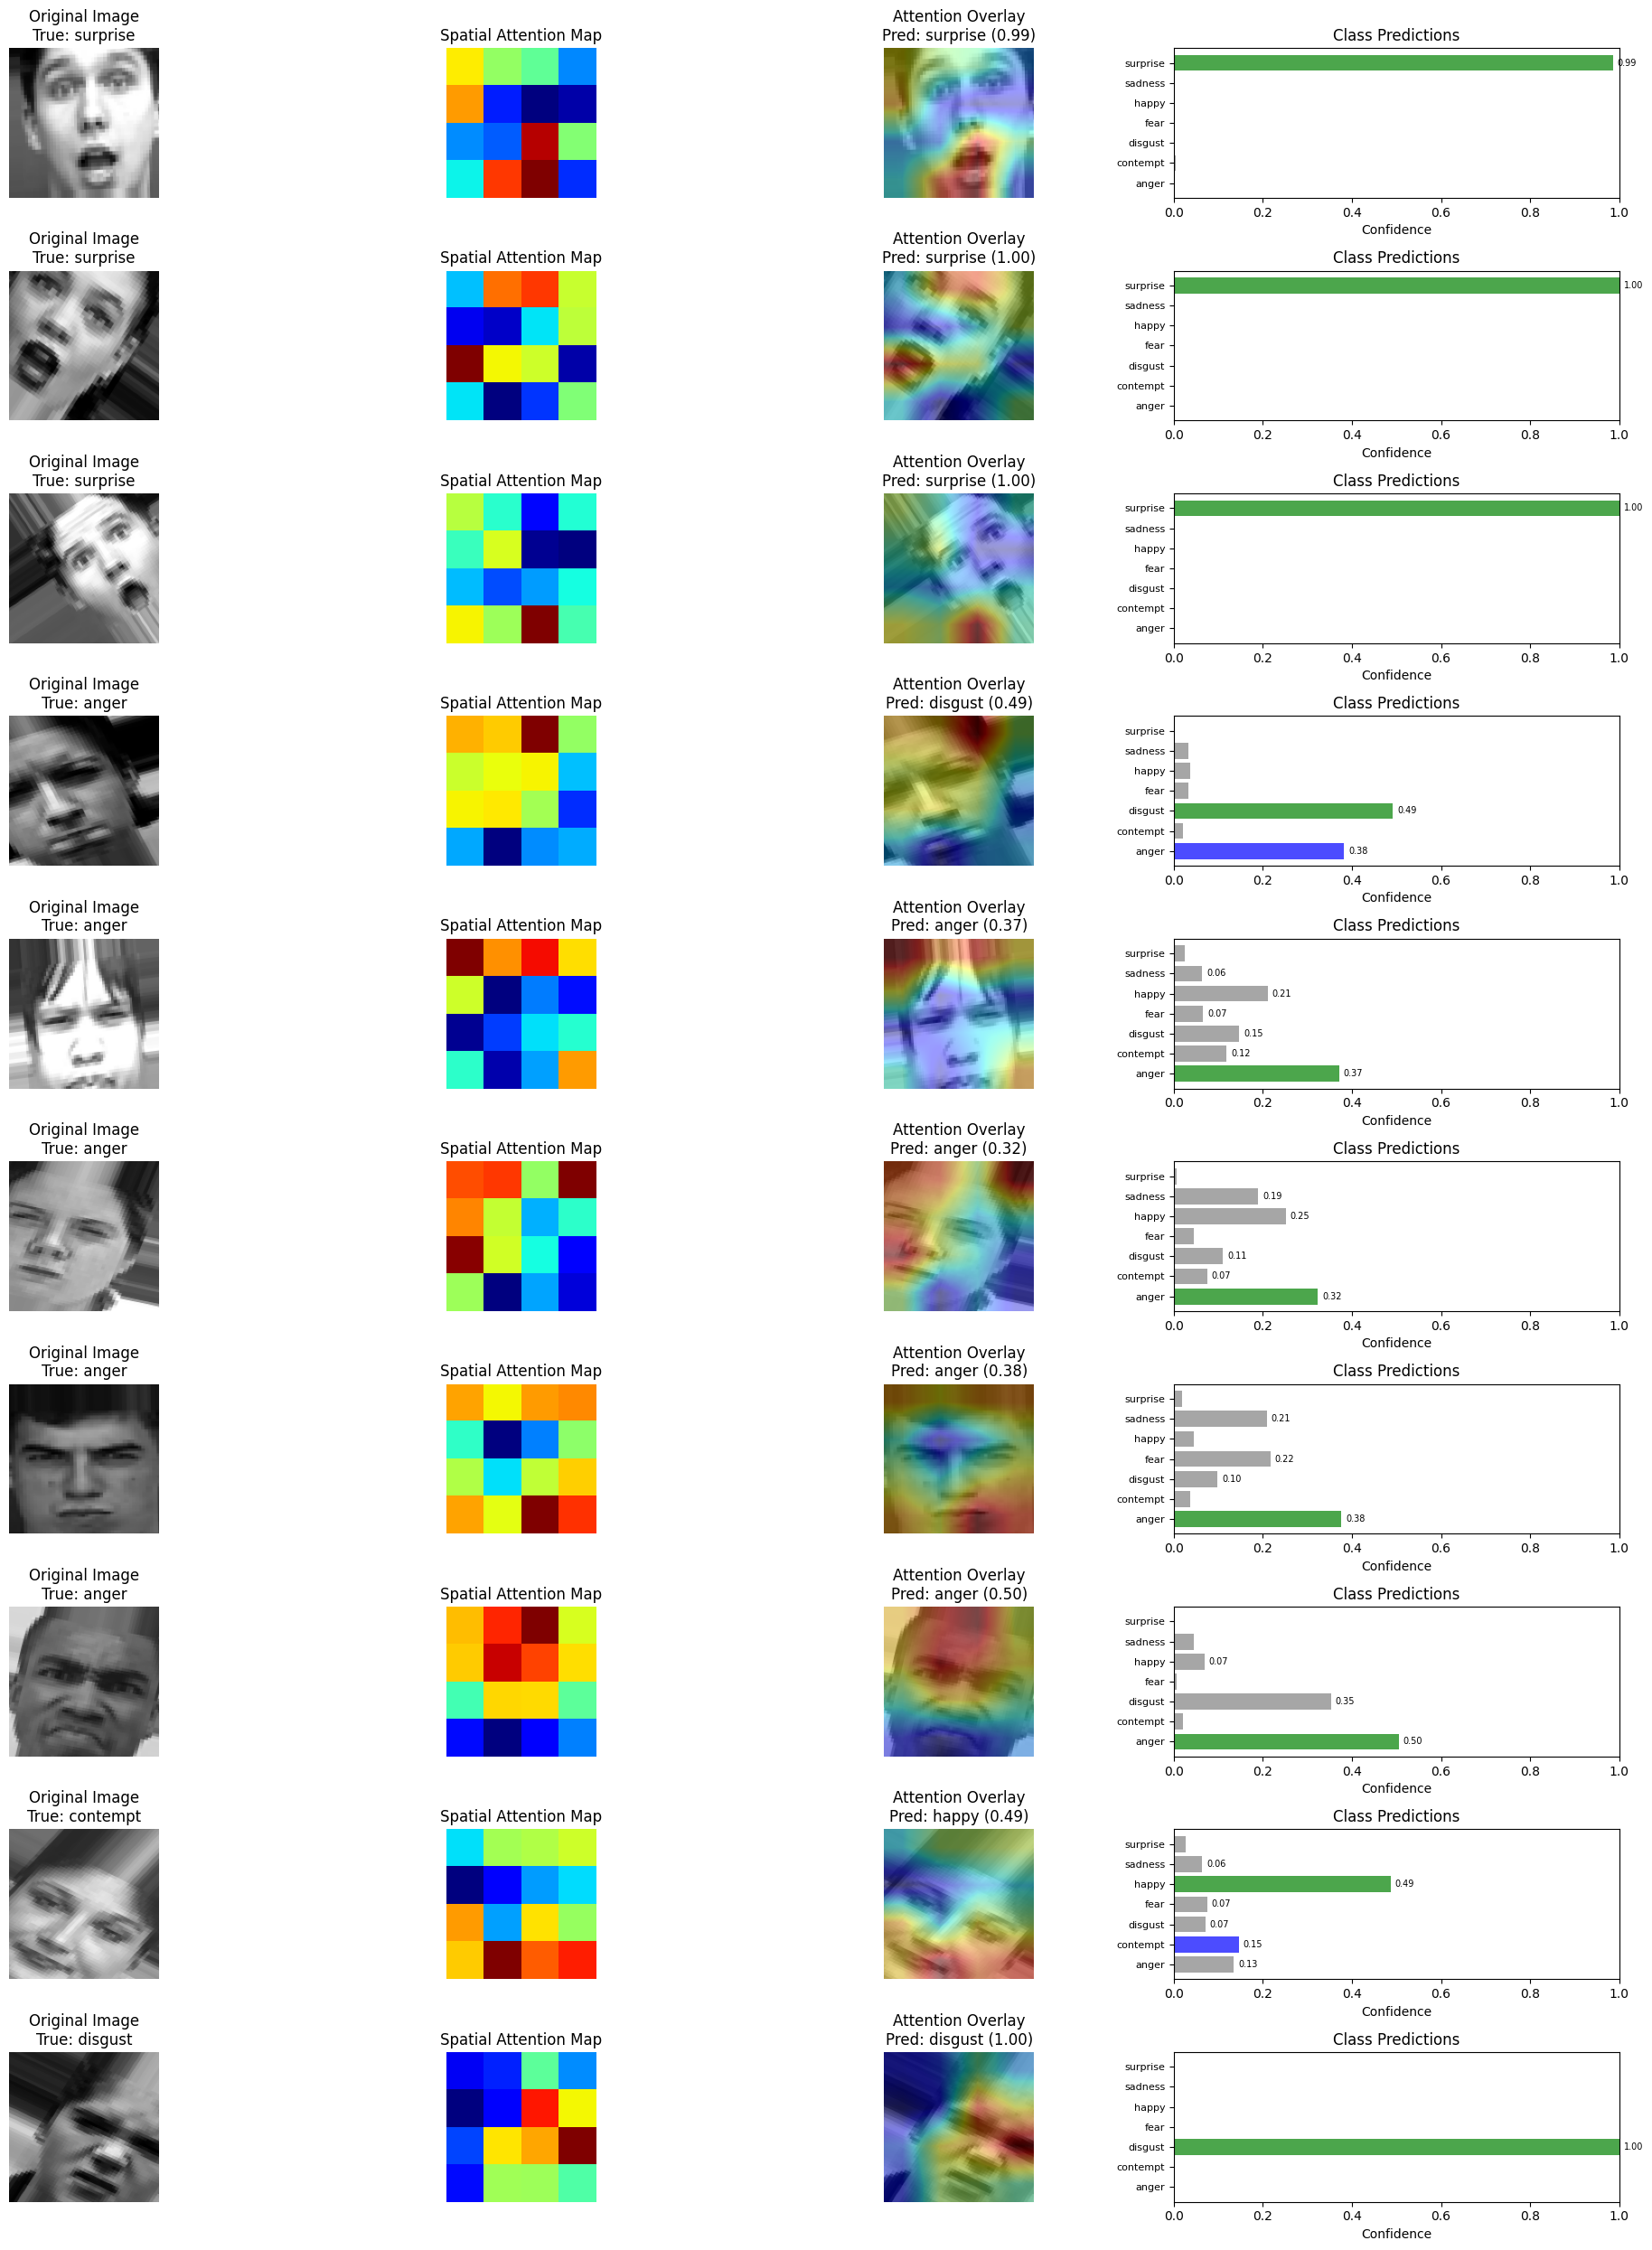

In [116]:
visualize_random_test_attention(mobile,val_generator, num_images=10)